Anteriormente se quizo aplicar una red neuronal recurrente, LSTM (Long short-term memory), para predecir el precio futuro de acciones individuales o de los valores de un mercado de valores. Sin embargo los pronósticos fueron bastante mal, en este cuaderno de Jupyter pleneo explorar un poco más este tipo de red e intentar predecir la evolución del mercado. Una buena representación del mercado de valores, llega a ser el S&P500.


In [ ]:
#importamos algunas paqueterias
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from numpy.random import seed
import yfinance as yf
seed(0)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Datos

In [ ]:
#Obtención de los datos
SyP = yf.Ticker("^GSPC")
SyP.info

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 5029.73,
 'open': 5031.13,
 'dayLow': 4999.52,
 'dayHigh': 5038.7,
 'regularMarketPreviousClose': 5029.73,
 'regularMarketOpen': 5031.13,
 'regularMarketDayLow': 4999.52,
 'regularMarketDayHigh': 5038.7,
 'volume': 2298707000,
 'regularMarketVolume': 2298707000,
 'averageVolume': 3964183442,
 'averageVolume10days': 4153973000,
 'averageDailyVolume10Day': 4153973000,
 'bid': 4956.48,
 'ask': 5044.18,
 'fiftyTwoWeekLow': 3808.86,
 'fiftyTwoWeekHigh': 5048.39,
 'fiftyDayAverage': 4813.122,
 'twoHundredDayAverage': 4485.0986,
 'currency': 'USD',
 'exchange': 'SNP',
 'quoteType': 'INDEX',
 'symbol': '^GSPC',
 'underlyingSymbol': '^GSPC',
 'shortName': 'S&P 500',
 'longName': 'S&P 500',
 'firstTradeDateEpochUtc': -1325583000,
 'timeZoneFullName': 'America/New_York',
 'timeZoneShortName': 'EST',
 'uuid': '8ffd55d1-3d1d-3733-a480-56768bc708e6',
 'messageBoardId': 'finmb_INDEXGSPC',
 'gmtOffSetMilliseconds': -18000000,
 'trailingPegRatio': No

In [ ]:
#importamos los datos desde el 2016
SyP_values = SyP.history(start="2016-01-01",end="2024-01-01")
SyP_values

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04 00:00:00-05:00,2038.199951,2038.199951,1989.680054,2012.660034,4304880000,0.0,0.0
2016-01-05 00:00:00-05:00,2013.780029,2021.939941,2004.170044,2016.709961,3706620000,0.0,0.0
2016-01-06 00:00:00-05:00,2011.709961,2011.709961,1979.050049,1990.260010,4336660000,0.0,0.0
2016-01-07 00:00:00-05:00,1985.319946,1985.319946,1938.829956,1943.089966,5076590000,0.0,0.0
2016-01-08 00:00:00-05:00,1945.969971,1960.400024,1918.459961,1922.030029,4664940000,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,0.0,0.0
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,0.0,0.0
2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,0.0,0.0


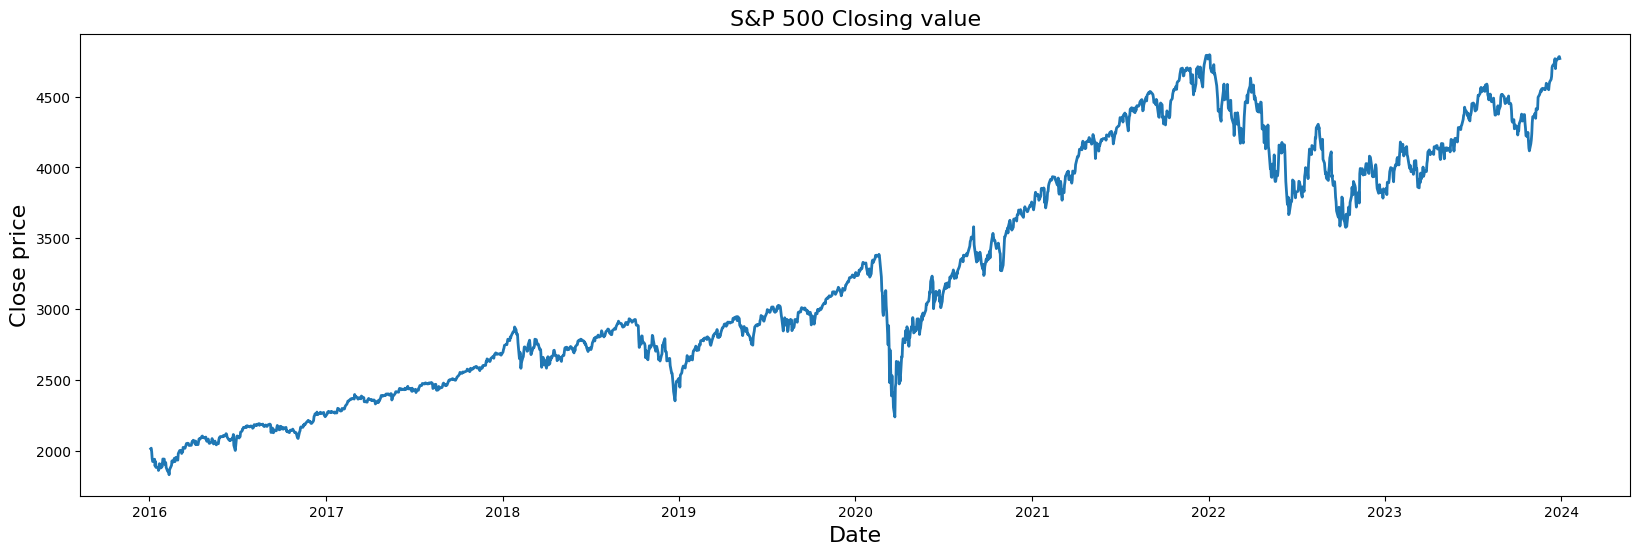

In [ ]:
#Graficamos el valor de cierre
plt.figure(figsize=(20,6))
plt.plot(SyP_values.index, SyP_values['Close'], lw=2)
plt.xlabel("Date")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close price", fontsize=16)
plt.title("S&P 500 Closing value", fontsize=16);

# Dividimos nuestros datos en datos de entrenamiento y prueba

Para los propósitos de este ejercicio, usemos los cuatro años de datos anteriores al año 2022 como nuestros datos de entrenamiento y usemos los datos desde principios de 2022 en adelante para la predicción.

In [ ]:
SyP_values.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2012 entries, 2016-01-04 to 2023-12-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2012 non-null   float64
 1   High          2012 non-null   float64
 2   Low           2012 non-null   float64
 3   Close         2012 non-null   float64
 4   Volume        2012 non-null   int64  
 5   Dividends     2012 non-null   float64
 6   Stock Splits  2012 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 125.8 KB


In [ ]:
# Eliminar las horas
SyP_values.index = SyP_values.index.date
# Convertir la columna Fecha a un formato de fecha
SyP_values.index = pd.to_datetime(SyP_values.index)
# Para evitar problemas mas adelante, construiremos una columna Date
SyP_values["Date"] = SyP_values.index

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# reescalar todo el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
#train_series = scaler.fit_transform(train_series)
SyP_values['Close'] = scaler.fit_transform(SyP_values[['Close']])

In [45]:
# train / test split
train_data = SyP_values[SyP_values.index <  "2020-01-01"]
test_data  = SyP_values[SyP_values.index >= "2020-01-01"]

In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Open          1006 non-null   float64       
 1   High          1006 non-null   float64       
 2   Low           1006 non-null   float64       
 3   Close         1006 non-null   float64       
 4   Volume        1006 non-null   int64         
 5   Dividends     1006 non-null   float64       
 6   Stock Splits  1006 non-null   float64       
 7   Date          1006 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 70.7 KB


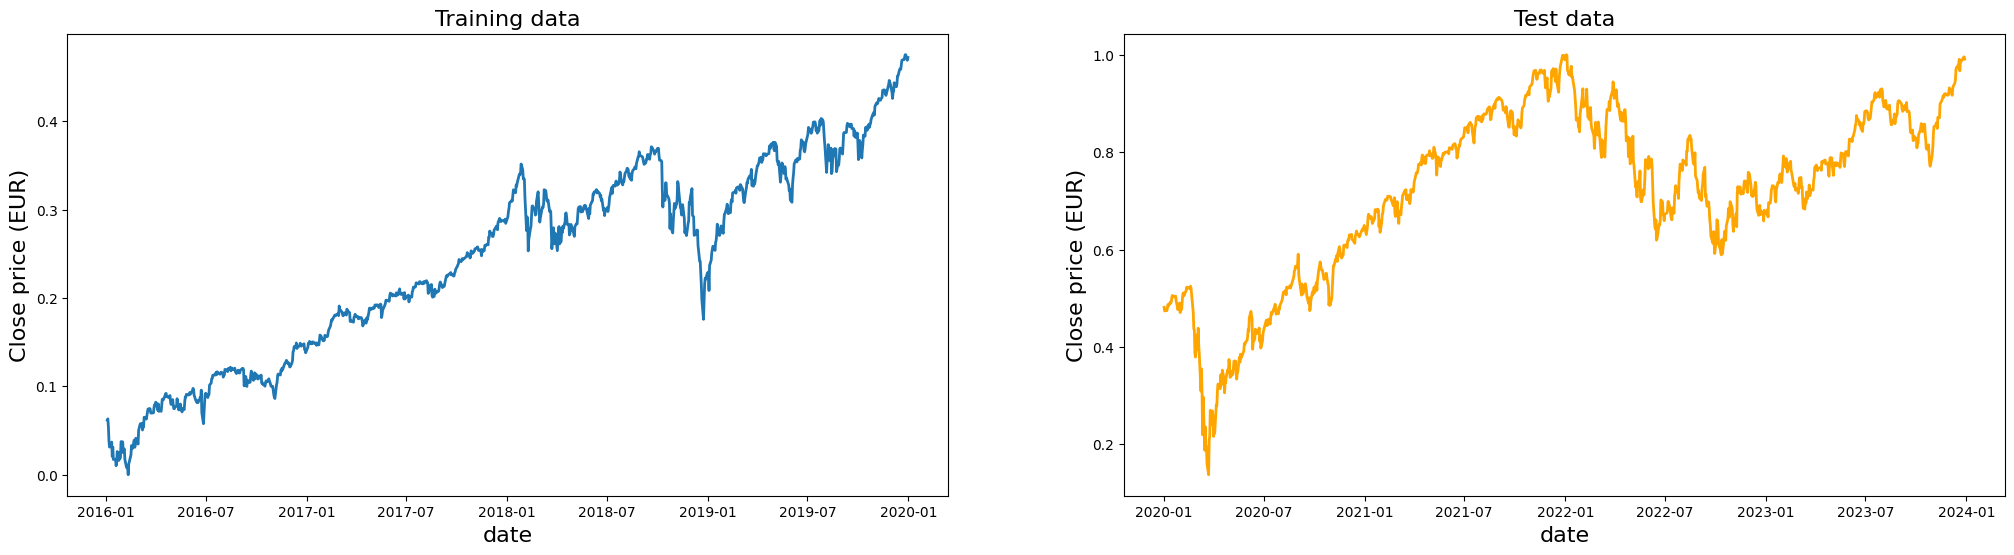

In [ ]:
# Graficamos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data['Date'], train_data['Close'], lw=2)
ax1.set_xlabel("date", fontsize=16)
ax1.set_ylabel("Close price (EUR)", fontsize=16)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data['Date'], test_data['Close'], c='orange', lw=2)
ax2.set_xlabel("date", fontsize=16)
ax2.set_ylabel("Close price (EUR)", fontsize=16)
ax2.set_title("Test data", fontsize=16);

# Construimos nuestra red neuronal LSTM

In [47]:
X_train = train_data.index
y_train = train_data['Close']

X_test = test_data.index
y_test = test_data['Close']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

Usaremos un look_back = 20. Esto significa que usaremos 20 puntos de datos anteriores para predecir el siguiente punto de datos.

In [26]:
%%time

from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 20

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_neurons  = 4
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');

model.fit(train_generator,epochs=300, verbose=0);

CPU times: user 4min 43s, sys: 8.31 s, total: 4min 51s
Wall time: 4min 18s


In [27]:
test_predictions  = model.predict(test_generator)

99/99 [==============================] - 2s 3ms/step


In [ ]:
# uncomment to undo the scaling
#test_data['Close'] = scaler.inverse_transform(test_data[['Close']])
#test_predictions   = scaler.inverse_transform(test_predictions)

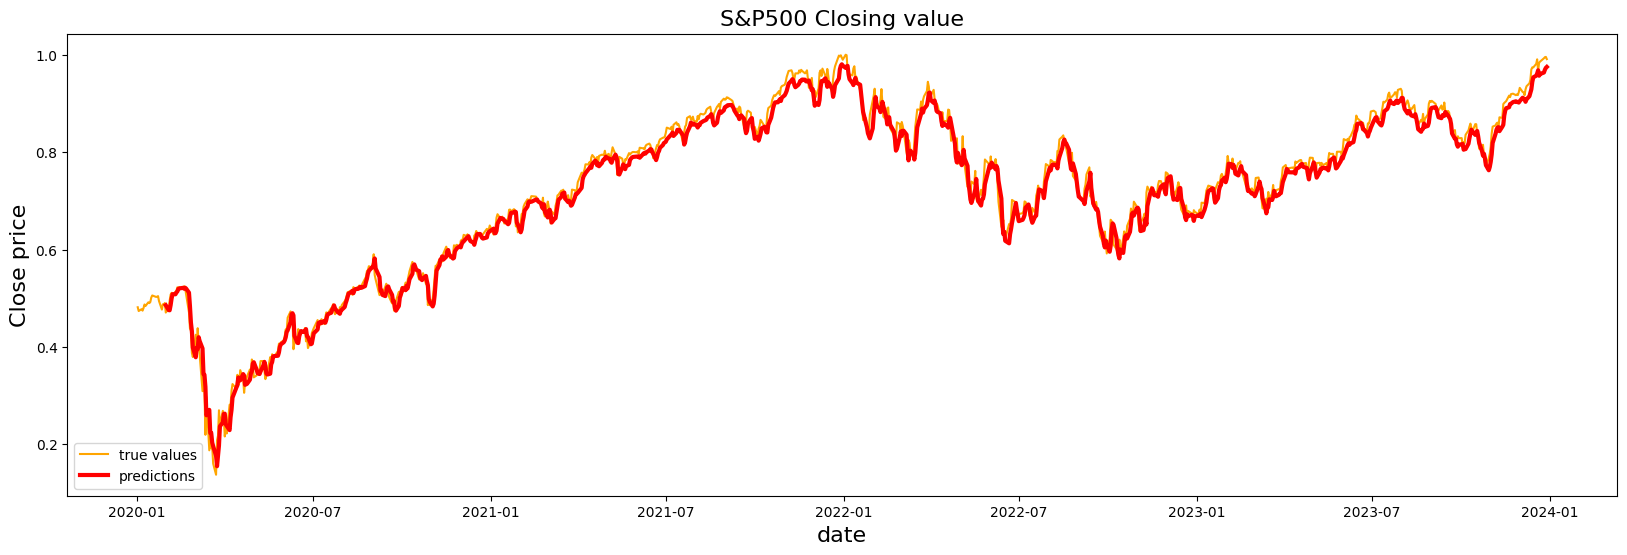

In [48]:
#graficamos nuevamente
plt.figure(figsize=(20,6))
plt.plot(test_data['Date'], test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price", fontsize=16)
plt.title("S&P500 Closing value", fontsize=16);

Predice correctamente nuestros datos de prueba. ¿Incluso el COVID?

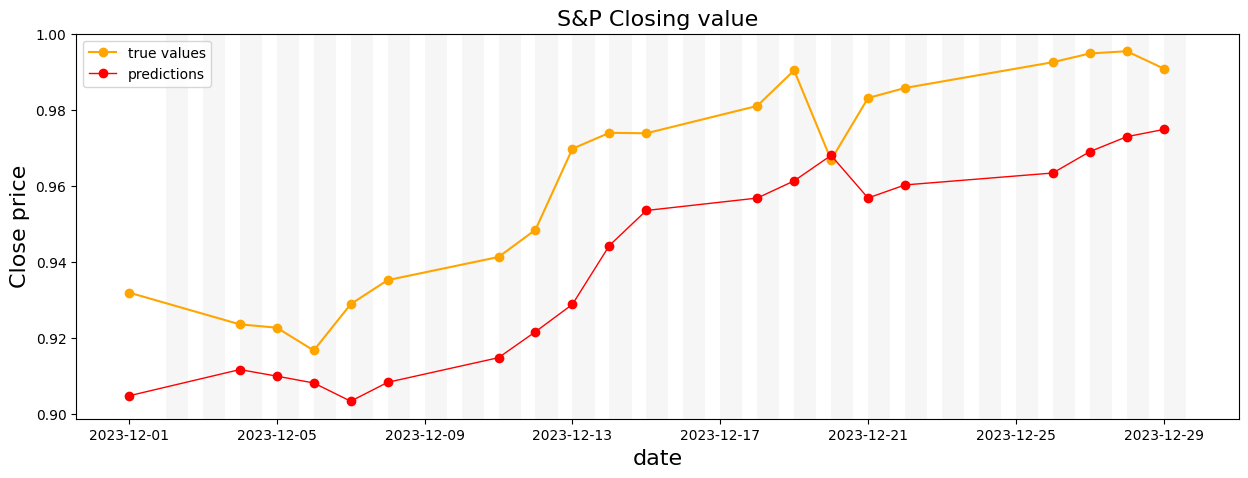

In [50]:
n_days = 20
last_n_days = len(test_data)-n_days

plt.figure(figsize=(15,5))
plt.plot(test_data.Date[last_n_days:], test_data['Close'][last_n_days:], c='orange',marker='o',label='true values')
plt.plot(X_test[last_n_days:],test_predictions[last_n_days-20:],lw=1, c='r', marker='o', label='predictions')
plt.legend(loc="upper left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price", fontsize=16)
plt.title("S&P Closing value", fontsize=16)

# shade in the days for better visualization
date2 = SyP_values.tail(1).index.item()
date1 = date2 - pd.Timedelta(days=n_days+7) # days added for weekends etc.
for i in pd.date_range(date1, date2, periods=n_days+8):
    # shade in 0.6 of each day
    plt.axvspan(i,i+pd.Timedelta(days=0.6), facecolor='lightgrey', alpha=0.2)
plt.show();

Podemos ver en esta escala que lo que realmente está sucediendo es que nuestras predicciones para cada día son básicamente el valor del día anterior, más un poco más.

# Extrapolación

Esta vez, en lugar de mirar hacia atrás en los últimos 20 valores de datos de prueba y predecir solo el siguiente valor, ahora mantendremos el valor de predicción y lo almacenaremos como parte de nuestros datos de entrada.


In [51]:
extrapolation = list()
seed_batch    = y_test[:look_back].values.reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(len(test_data)):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value)
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 [==============================] - 0s 35ms/step


Ahora echemos un vistazo a los resultados y veamos nuestro modelo LSTM en todo su esplendor.

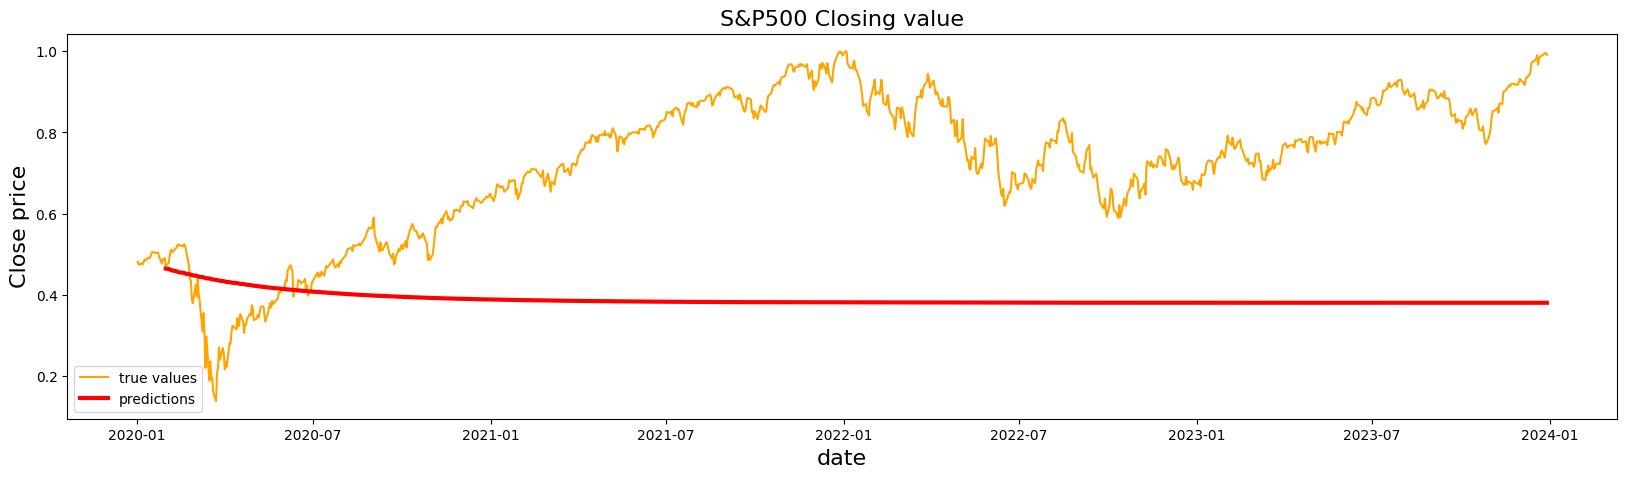

In [53]:
plt.figure(figsize=(20,5))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],extrapolation[20:], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price", fontsize=16)
plt.title("S&P500 Closing value", fontsize=16);

De esta forma podemos ver lo que realmente está pasando; la red neuronal predice que el precio de las acciones de hoy es básicamente el precio de las acciones de ayer + un poco (de ahí el ligero gradiente). Nuestras predicciones iniciales parecían buenas porque, a gran escala, no notamos que nuestro modelo básicamente imitaba el precio de ayer.


# ¿Qué salió mal?

¿Por qué fallamos? En los datos del mercado de valores suceden muchas más cosas de las que pueden captarse simplemente observando una serie univariada de valores históricos. Los precios de las acciones no son el resultado de un par de factores causales subyacentes, sino más bien de una multitud de contribuciones, así como de una buena dosis de irracionalidad humana (Kahneman, Thaler). De hecho, se ha postulado que los datos bursátiles son casi aleatorios (Fama, Malkiel).

Trazamos un histograma del cambio porcentual diario en el valor de Cierre en nuestros datos de entrenamiento y lo comparamos con una distribución normal, obtenida del teorema del límite central:


<ipython-input-54-131d7ab8b095>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pct_change'] = train_data.Close.pct_change(periods = 1)


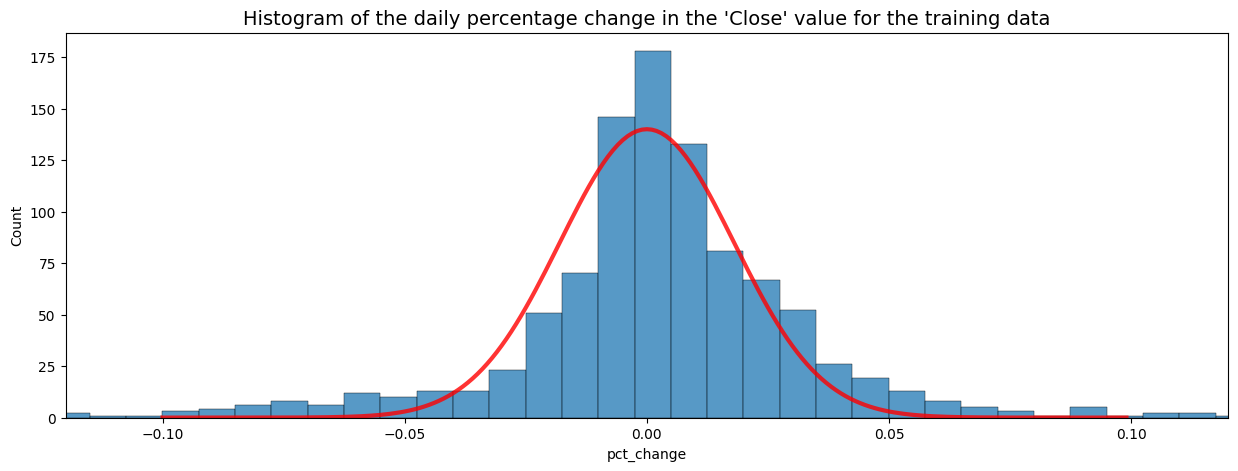

In [54]:
train_data['pct_change'] = train_data.Close.pct_change(periods = 1)

x = np.arange(-0.1, 0.1, 0.001)

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

plt.figure(figsize = (15,5))
ax = sns.histplot(train_data['pct_change'], binwidth=0.0075)
# overlay a Gaussian distribution, parameters were picked by eye
ax = plt.plot(x,Gaussian(x,0,0.018,140),color='r',lw=3,label='Gaussian #1', alpha=0.8)
plt.title("Histogram of the daily percentage change in the 'Close' value for the training data", size=14)
plt.xlim(-0.12, 0.12);

De hecho, parece casi normal, aunque con algunas colas pesadas. ¿Podrían nuestros datos de entrenamiento ser realmente solo un paseo aleatorio? Una cosa que podemos hacer es mirar un correlograma. Dado que el siguiente punto de un paseo aleatorio comienza desde el punto anterior, debemos observar las diferencias entre los valores posteriores, en lugar de los valores reales en sí.


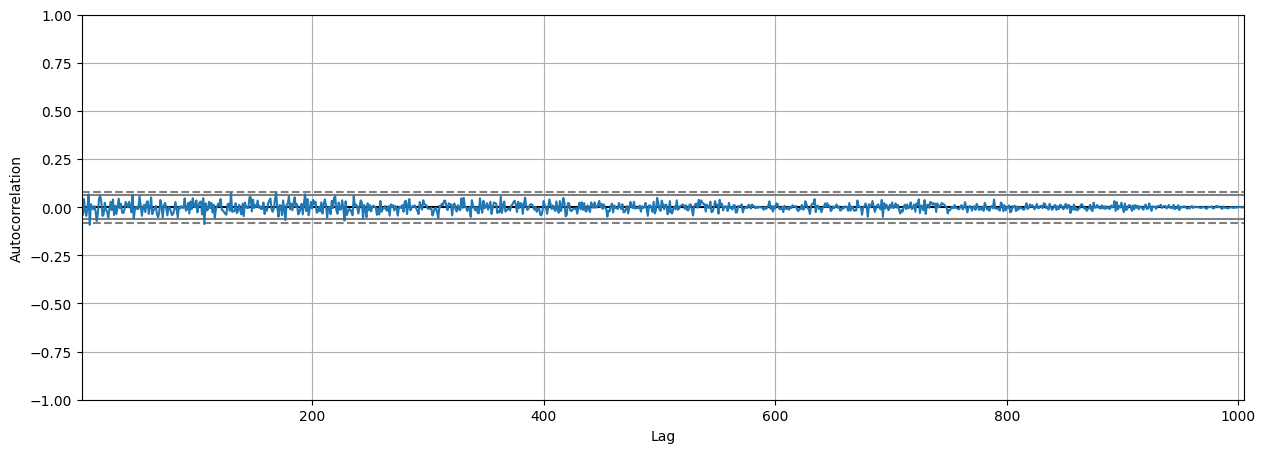

In [55]:
diff_train_data_close = train_data['Close'].diff()
# drop the initial nan
diff_train_data_close = diff_train_data_close.dropna()
# now for the autocorrelation plot
rcParams['figure.figsize'] = 15, 5
pd.plotting.autocorrelation_plot(diff_train_data_close);

Ciertamente parece que estamos ante un paseo aleatorio, ya que no hay indicios de autocorrelación para ningún retraso.

Básicamente, nuestro LSTM no encontró nada de valor real para modelar y, por lo tanto, tomó el valor promedio, junto con una ligera pendiente; estaríamos igualmente bien con un modelo extremadamente simplista de la forma

Esto se conoce como pronóstico ingenuo o modelo de persistencia. Para un paseo aleatorio, dado que por definición el siguiente valor no se puede predecir, utilizar el valor actual para el siguiente valor, es decir, el pronóstico ingenuo de un solo paso, teóricamente da los mejores resultados posibles.

Comparemos nuestro modelo LSTM con un pronóstico tan ingenuo.

In [56]:
# Crear el pronostico ingenuo
test_data['naive'] = test_data['Close'].shift(1)

<ipython-input-56-f4e88ba14823>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['naive'] = test_data['Close'].shift(1)


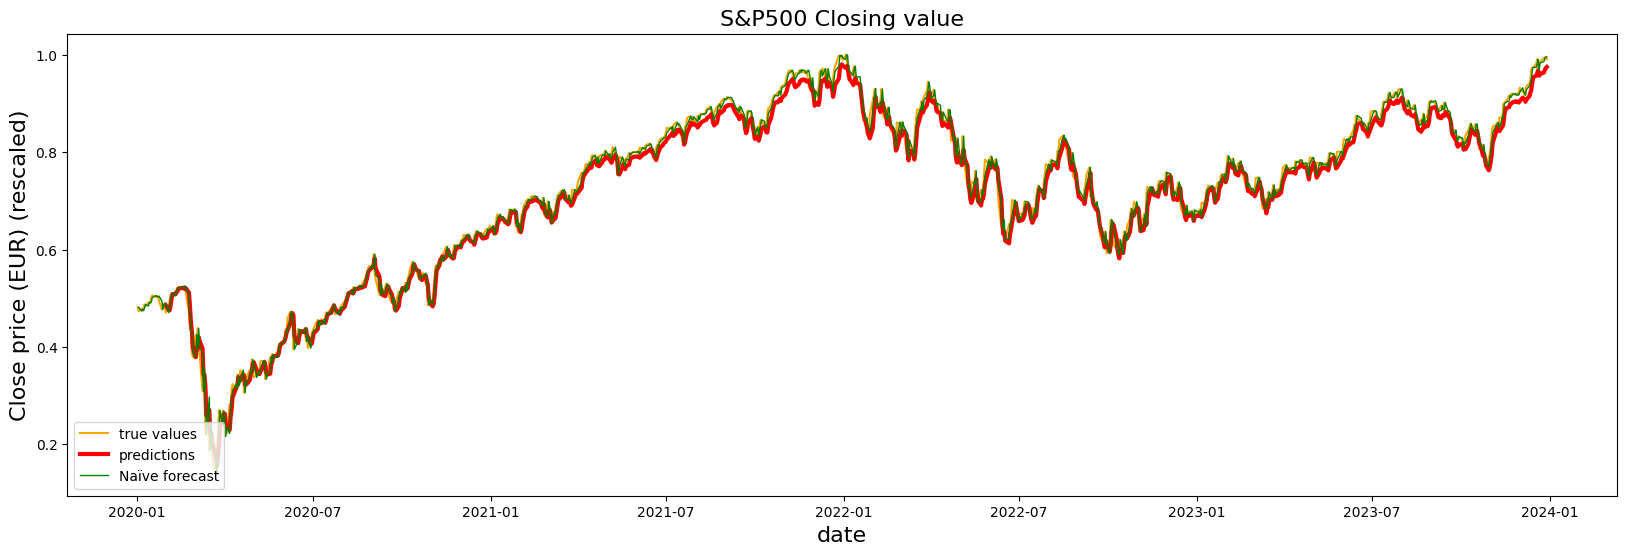

In [59]:
plt.figure(figsize=(20,6))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.plot(test_data.Date,test_data['naive'], lw=1, c='green',linestyle = '-', label='Naïve forecast')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("S&P500 Closing value", fontsize=16);

# Rendimiento del modelo

In [58]:
# Primero cree un pad de longitud "look_back"
twenty_zeros = np.zeros((look_back,1))
# ahora inserte las predicciones de LSTM en el marco de datos
test_data["LSTM"] = np.concatenate([twenty_zeros,test_predictions])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Naïve model MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))
print("Naïve model MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))

Naïve model MSE: 0.0003
LSTM model  MSE: 0.0004
Naïve model MAE: 0.0092
LSTM model  MAE: 0.0135


<ipython-input-58-88921e3112df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["LSTM"] = np.concatenate([twenty_zeros,test_predictions])


Podemos ver claramente que el modelo ingenuo supera fácilmente al modelo LSTM.